<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="4"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>Entity Resolution in Dissimilarity Spaces  <br></b> 
    </font>
     <br>
     <font size="3">
        Results notebook     
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos, BS Student</b>
     </font>
</div>
<br>
<div align="center"> 
    <font size="4">
     <b> Dr. Alex Delis</b>,  Professor NKUA <br> 
     <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Code injection__

## Import of libraries

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx
import itertools 
import sklearn
import plotly.express as px
import logging
import sys
import optuna

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

# plt.style.use('seaborn-white') # plot style

Automated refresh on the notebook

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Main model dependency

In [3]:
from model import RankedWTAHash, customClassificationReport, report, set_params

## Utilities

In [4]:
from utils.classification import MMD2, myMMD2
from plot.heatmap import myHeatmap
from plot.confusion_matrix import create_ConfusionMatrix
from plot.dimension_reduction import SpaceVisualization2D, SpaceVisualization3D, SpaceVisualizationEmbeddings2D, SpaceVisualizationEmbeddings3D
from plot.heatmap import similarityProbsHeatMap, similarityProbsHeatMapWithClusters

### Dataset utils

In [5]:
from datasets.common.create_dataset import createDataset, createTrueLabels

### GridSearch function

In [6]:
from utils.grid_search import GridSearch

### Custom metrics

In [7]:
from utils.metrics import spearman_footrule_distance, kendall_top_k, rbo


# __Dataset injection__

## Load data from Drive in Colab

In [8]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [8]:
CORA_groundTruth = os.path.abspath("../data/coraIdDuplicates.csv")
CORA = os.path.abspath("../data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth,sep='|',header=None,names=['id1','id2'])
CORA_groundTruth=CORA_groundTruth.sort_values(by=['id1','id2'],ignore_index=True)
CORA = pd.read_csv(CORA,sep='|')
CORA

Entity Id            address  \
0             0  los alamitos, ca:   
1             1                NaN   
2             2                NaN   
3             3                NaN   
4             4                NaN   
...         ...                ...   
1290       1290                NaN   
1291       1291                NaN   
1292       1292                NaN   
1293       1293                NaN   
1294       1294                NaN   

                                                 author  \
0     p. auer, n. cesa-bianchi, y. freund, and r. e....   
1     a. blum, m. furst, m. j. kearns, and richard j...   
2     avrim blum, merrick furst, michael kearns, and...   
3     avrim blum, merrick furst, michael kearns, and...   
4              a. blum, m. furst, m. kearns, r. lipton.   
...                                                 ...   
1290               robert e. schapire and yoram singer.   
1291  schapire, r. e., freund, y., bartlett, p., & l...   
1292   robert e. schapire and yoram singer. boostexter:   
1293                   robert e. schapire yoram singer.   
1294                   robert e. schapire yoram singer.   

                              editor institution month  \
0                                NaN         NaN   NaN   
1                                NaN         NaN   NaN   
2                                NaN         NaN   NaN   
3     in douglas r. stinson, editor,         NaN   NaN   
4                                NaN         NaN   NaN   
...                              ...         ...   ...   
1290                             NaN         NaN   NaN   
1291                             NaN         NaN   NaN   
1292                             NaN         NaN   NaN   
1293                             NaN         NaN   NaN   
1294                             NaN         NaN   NaN   

                                            note              pages  \
0                                            NaN       pp. 322-331.   
1                                            NaN  pages 24.1-24.10,   
2                                            NaN  pages 24.1-24.10,   
3     lecture notes in computer science no. 773.     pages 278-291.   
4                                            NaN                NaN   
...                                          ...                ...   
1290                                         NaN                NaN   
1291           annals of statistics (to appear).                NaN   
1292                                         NaN                NaN   
1293               submitted for publication. 17                NaN   
1294                  submitted for publication.                NaN   

                         publisher  \
0     ieee computer society press,   
1                              NaN   
2                              NaN   
3                        springer,   
4                              NaN   
...                            ...   
1290                           NaN   
1291                           NaN   
1292                           NaN   
1293                           NaN   
1294                           NaN   

                                                  title  \
0     'gambling in a rigged casino: the adversarial ...   
1     cryptographic primitives based on hard learnin...   
2     cryptographic primitives based on hard learnin...   
3     cryptographic primitives based on hard learnin...   
4     cryptographic primitives based on hard learnin...   
...                                                 ...   
1290  improved boosting algorithms using confidence-...   
1291  boosting the margin: a new explanation for the...   
1292  a system for multiclass multi-label text categ...   
1293  improved boosting algorithms using confidence-...   
1294  improved boosting algorithms using confidence-...   

                                                  venue volume     year  \
0     in proc. 36th annual symposium on foundatio

In [10]:
CORA_groundTruth.head(10)

id1  id2
0    1    2
1    1    3
2    1    4
3    2    3
4    2    4
5    3    4
6    5    6
7    5    7
8    5    8
9    5    9

#### CENSUS

In [11]:
CENSUS_groundTruth = os.path.abspath("../data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("../data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
# CENSUS

In [12]:
# CENSUS_groundTruth

#### CDDB

In [13]:
CDDB_groundTruth = os.path.abspath("../data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("../data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
# CDDB

In [14]:
# CDDB_groundTruth

#### DBLP - ACM

In [15]:
ACM = os.path.abspath("../data/ACM.csv")
DBLP = os.path.abspath("../data/DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("../data/DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### CORA - 1st edition

In [16]:
fpcora = os.path.abspath("../data/cora1stEdition/CORA.xml")
fpcora_gold = os.path.abspath("../data/cora1stEdition/cora_gold.csv")
CORA1 = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
CORA1['@id'] = pd.to_numeric(CORA1['@id']).subtract(1)
CORA1_groundTruth = pd.read_csv(fpcora_gold,sep=';')
CORA1_groundTruth['id1'] = pd.to_numeric(CORA1_groundTruth['id1']).subtract(1)
CORA1_groundTruth['id2'] = pd.to_numeric(CORA1_groundTruth['id2']).subtract(1)

# __CORA Evaluation__

### Shuffle data

In [9]:
CORA_shuffled = CORA.sample(frac=1).reset_index(drop=True)
# CORA_shuffled

In [25]:
fields = [
     'address',
     'author',
     'editor',
     'institution',
     'month',
     'note',
     'pages',
     'publisher',
     'title',
     'venue',
     'volume',
     'year',
     'Unnamed: 13'
]

# fields = [
#      'author',
#      'title',
# ]


# CORA
data, true_matrix = createDataset(CORA, CORA_groundTruth, fields, 'Entity Id')

# Toy CORA
# data, true_matrix = createDataset(CORA.head(15), CORA_groundTruth.head(50), fields, 'Entity Id')

# Old CORA
# data, true_matrix = createDataset(CORA1, CORA1_groundTruth, fields, '@id')

Creating dataset from imput files: 0it [00:00, ?it/s]

Creating groundtruth matrix: 0it [00:00, ?it/s]

__Clique construction for visualization purposes__

In [26]:
labels_groundTruth, numOfObjWithoutDups, groups = createTrueLabels(CORA['Entity Id'].tolist(),CORA_groundTruth)            
data_length = [ len(x) for x in data ]

### CORA inspection

In [27]:
specs = {
    'Objects without any duplicates' : numOfObjWithoutDups-len(groups), 
    'Objects with at least one duplicate' : sum([len(x) for x in groups]),
    'Total number of objects' : CORA.shape[0], 
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length), 
    'Median length' : np.median(data_length)
}
specsCoraDf = pd.DataFrame(list(specs.items()), columns=['Spec','#number'])
specsCoraDf[['#number']] = specsCoraDf[['#number']].astype(int)
specsCoraDf

Spec  #number
0       Objects without any duplicates       19
1  Objects with at least one duplicate     1276
2              Total number of objects     1295
3                Number of ER clusters       93
4                         Dataset size     1295
5                       Average length      164
6                           Min length       38
7                           Max length      366
8                        Median length      164

#### Dataset attributes

In [21]:
list(CORA.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

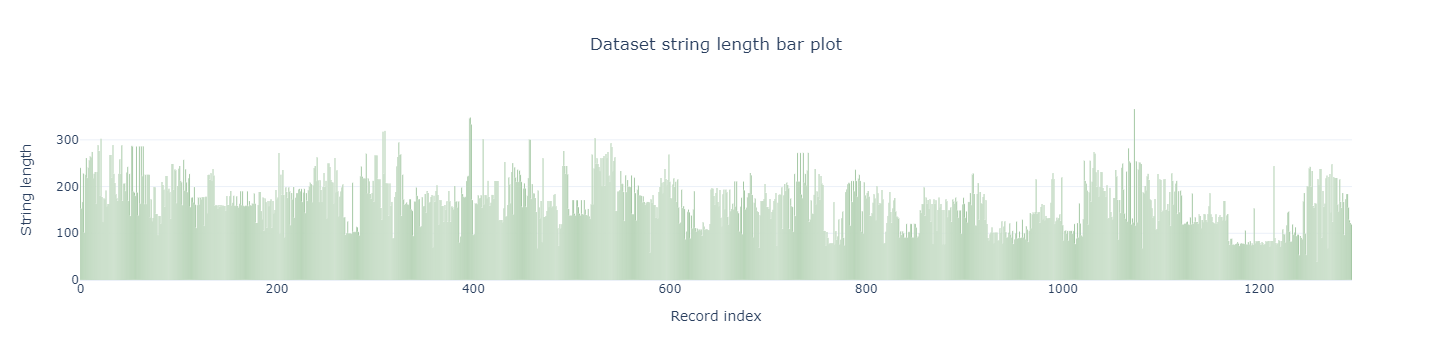

In [28]:
df = pd.DataFrame({"Record index":range(0,len(data_length),1),"String length":data_length})
fig = px.bar(df, x= "Record index", y="String length", title="Dataset string length bar plot",template='plotly_white')
fig.update_traces(marker_color='darkgreen')
fig.update_layout(title_x=0.5)
fig.show()

### CORA: Jaccard execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/1000 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/910 [00:00<?, ?it/s]


- Final number of prototypes:  221

# Finished in 11.005 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]

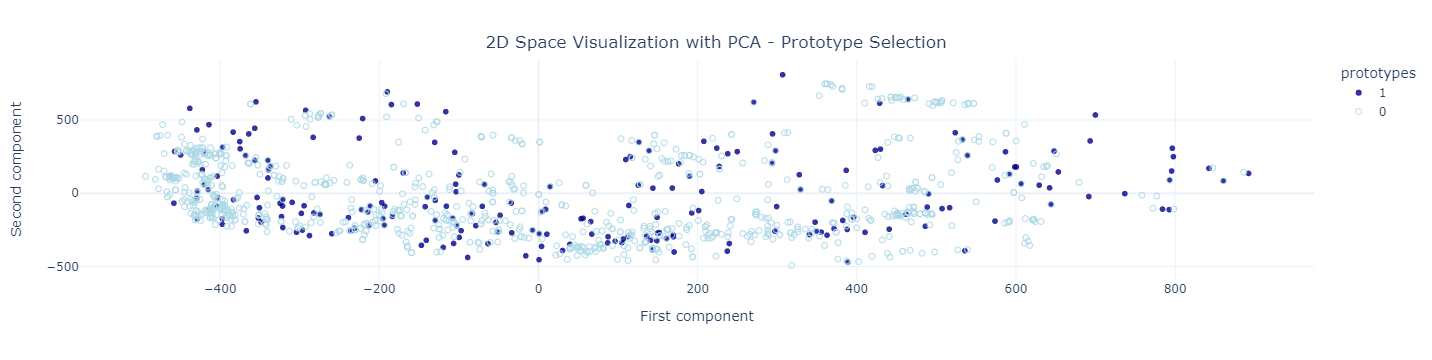


# Finished in 7.7604 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  159



# Finished in 0.5383 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/159 [00:00<?, ?it/s]


- Total number of comparisons made:  222990
- Total number of comparisons of same objects:  29714
- Total number of comparisons of same objects with success:  25842
- Total number of comparisons of different objects with success:  172651

# Finished in 62.433 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.54 %
F1-Score:  53.93 %
Recall:    70.37 %
Precision: 43.72 %
Wall time: 1min 22s


In [42]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_dissimilarityDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'euclid_jaccard'                   # Distance metric between the strings when creating the space
prototypesFilterThr = 0.6                   # Prototypes must differ more than that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid_jaccard'  # Embedding metric

# WTA algorithm
windowSize = 100                           # Vector size for WTA algo
number_of_permutations = 3                # WTA number of permutations

# Similarity evaluation
similarityVectors = 'ranked'                  # which vectors will be passed to WTA step
similarityThreshold = 0.6                    # Similarity threshold for the final step
metric = 'kendal'                             # Similarity metric between vectors

start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,
    max_dissimilarityDistance= max_dissimilarityDistance,
    windowSize= windowSize,
    similarityThreshold= similarityThreshold,
    metric=metric,
    similarityVectors=similarityVectors,
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr,
    verboseLevel = 1
)
model.hackForDebug(labels_groundTruth, true_matrix)
model = model.fit(data)
acc,f1,precision,recall = model.evaluate(model.mapping_matrix, true_matrix)

### Space Visualization

In [ ]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray, withPlotly=False)

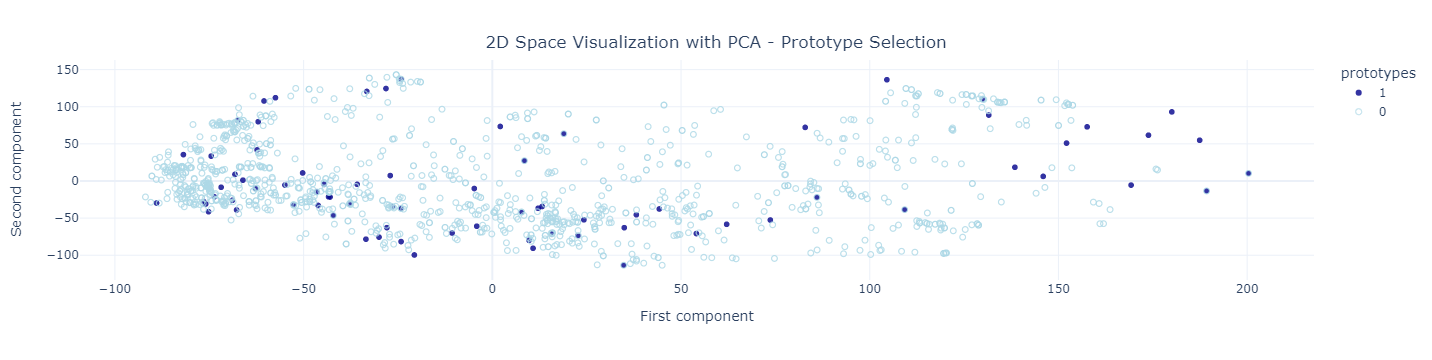

In [149]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray)

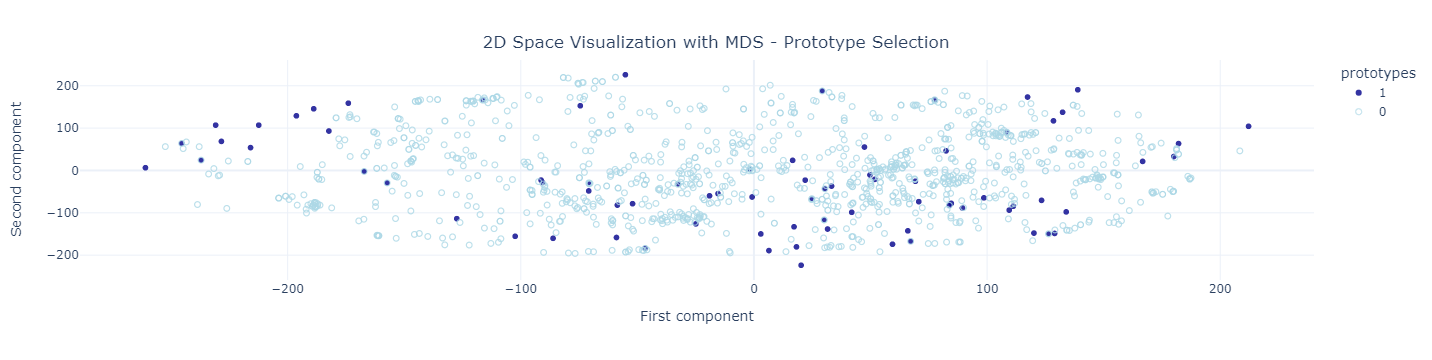

In [150]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(model.Embeddings,model.prototypeArray)

In [ ]:
SpaceVisualization3D(model.rankedVectors,model.prototypeArray, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(model.rankedVectors, model.prototypeArray, withPlotly = False, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(model.rankedVectors, model.prototypeArray, withPlotly = True, decompositionMenthod='MDS')

In [ ]:
SpaceVisualizationEmbeddings2D(
    model.Embeddings, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    model.rankedVectors, labels_groundTruth, withPlotly=False, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    model.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    model.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='MDS'
)

### MMD${}^2$ error between distribution of Prototypes and whole Dataset

In [ ]:
myMMD2(model)

## Gridsearch with Optuna

In [46]:
speedUpRate = 9

Results dataframe

In [28]:
results_dataframe = pd.DataFrame(
    columns=['maxNumberOfClusters','maxDissimilarityDistance','similarityThreshold',
             'windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric",
             "numberOfPermutations","ngramms","jaccardWithChars", 
             "numOfComparisons", "diffObjectsComparedSuccess", "sameObjectsCompared", "sameObjectsComparedSuccess",
             "selectionVariance","selectedNumOfPrototypes","averageBucketSize",
             'Accuracy','Precision','Recall','F1','Time']
)

In [48]:
def objective(trial):

#     ngramms= trial.suggest_int("ngramms", 2, 3) 
#     jaccard_withchars = trial.suggest_categorical("jaccard_withchars", [True, False])
#     max_numberOf_clusters= trial.suggest_int("max_numberOf_clusters", 500, 1500) 
#     distanceMetric = trial.suggest_categorical("distanceMetric", ["jaccard", "euclid_jaccard"])
#     max_dissimilarityDistance= trial.suggest_float("max_dissimilarityDistance", 0.3, 0.8)
#     prototypesFilterThr = trial.suggest_float("prototypesFilterThr", 0.5, 0.9)
#     # --- Embedding phase
#     distanceMetricEmbedding = trial.suggest_categorical("distanceMetricEmbedding", ["l_inf", "jaccard", "euclid_jaccard"])
#     # -- WTA algorithm
#     windowSize= trial.suggest_int("windowSize", 15, 80) 
#     number_of_permutations= trial.suggest_int("number_of_permutations", 1, 5) 
#     # -- Similarity evaluation
#     similarityVectors = trial.suggest_categorical("similarityVectors", ["initial"])
#     similarityThreshold = trial.suggest_float("similarityThreshold", 0.6, 0.8)
#     metric = trial.suggest_categorical("metric", ["pearson", "spearman", "kendal", "rbo"])
    ngramms= 3 
    jaccard_withchars = trial.suggest_categorical("jaccard_withchars", [True])
    max_numberOf_clusters= trial.suggest_int("max_numberOf_clusters", 500, 1000) 
    distanceMetric = "euclid_jaccard"
    max_dissimilarityDistance= trial.suggest_float("max_dissimilarityDistance", 0.3, 0.8)
    prototypesFilterThr = trial.suggest_float("prototypesFilterThr", 0.5, 0.7)
    # --- Embedding phase
    distanceMetricEmbedding = "euclid_jaccard"
    # -- WTA algorithm
    windowSize= trial.suggest_int("windowSize", 25, 100) 
    number_of_permutations= trial.suggest_int("number_of_permutations", 1, 5) 
    # -- Similarity evaluation
    similarityVectors = "ranked"
    similarityThreshold = trial.suggest_float("similarityThreshold", 0.6, 0.8)
    metric = "kendal"
    
    start = time.time()
    model = RankedWTAHash(
        max_numberOf_clusters= max_numberOf_clusters,
        max_dissimilarityDistance= max_dissimilarityDistance,
        windowSize= windowSize,
        similarityThreshold= similarityThreshold,
        metric=metric,
        similarityVectors=similarityVectors,
        number_of_permutations = number_of_permutations,
        distanceMetric= distanceMetric,
        distanceMetricEmbedding = distanceMetricEmbedding,
        ngramms= ngramms,
        jaccard_withchars = jaccard_withchars,
        prototypesFilterThr = prototypesFilterThr,
        verboseLevel = 0,
        maxNumberOfComparisons = int((CORA.shape[0]*CORA.shape[0])/speedUpRate)
#         disableTqdm = True
    )
    model.hackForDebug(labels_groundTruth, true_matrix)
    model = model.fit(data)
    if model == None:
        precision = 0.0
        f1 = 0.0
        recall = 0.0
    else:
        acc,f1,precision,recall = model.evaluate(model.mapping_matrix, true_matrix)
    exec_time = time.time() - start
#     results_dataframe.loc[len(results_dataframe)+1] = [
#         max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,
#         windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,
#         number_of_permutations,ngramms,jaccard_withchars, 
#         model.numOfComparisons, model.diffObjectsComparedSuccess, model.sameObjectsCompared, model.sameObjectsComparedSuccess,
#         model.selectionVariance,model.selected_numOfPrototypes,len(model.buckets.keys()),acc,precision,recall,f1,exec_time]

    return recall

In [49]:
# Add stream handler of stdout to show the messages
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
import datetime
x = datetime.datetime.now()
study_name = "best-params-jaccard-recall-" + x.strftime("%d-%m_%H:%M")  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(directions=["maximize"], study_name=study_name, storage=storage_name, load_if_exists=True)

print("Number of finished trials: ", len(study.trials))

[I 2021-12-11 15:32:04,142] A new study created in RDB with name: best-params-jaccard-recall-11-12_15:32


Number of finished trials:  0


In [51]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

C:\Users\nikol\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/963 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/963 [00:00<?, ?it/s]


- Final number of prototypes:  180

# Finished in 12.326 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.4866 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  27

# Finished in 0.0910 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/27 [00:00<?, ?it/s]


# Finished in 21.158 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.34 %
F1-Score:  53.89 %
Recall:    47.43 %
Precision: 62.39 %
[I 2021-12-11 16:18:36,122] Trial 30 finished with value: 47.4278398510242 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 963, 'max_dissimilarityDistance': 0.37167184832106126, 'prototypesFilterThr': 0.6116130185167351, 'windowSize': 75, 'number_of_permutations': 1, 'similarityThreshold': 0.6264372608845521}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/973 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/769 [00:00<?, ?it/s]


- Final number of prototypes:  140

# Finished in 8.4035 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.1679 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  85

# Finished in 0.1250 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/85 [00:00<?, ?it/s]

[I 2021-12-11 16:19:38,390] Trial 31 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 973, 'max_dissimilarityDistance': 0.6179047149867372, 'prototypesFilterThr': 0.6894863405959725, 'windowSize': 62, 'number_of_permutations': 2, 'similarityThreshold': 0.6398380963644302}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/999 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/607 [00:00<?, ?it/s]


- Final number of prototypes:  153

# Finished in 4.8937 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.3941 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  94

# Finished in 0.4322 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/94 [00:00<?, ?it/s]


# Finished in 31.629 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.71 %
F1-Score:  67.79 %
Recall:    66.10 %
Precision: 69.57 %
[I 2021-12-11 16:20:21,551] Trial 32 finished with value: 66.10218808193669 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 999, 'max_dissimilarityDistance': 0.798251310518002, 'prototypesFilterThr': 0.6624352761550342, 'windowSize': 65, 'number_of_permutations': 2, 'similarityThreshold': 0.6631899955967138}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/911 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/608 [00:00<?, ?it/s]


- Final number of prototypes:  150

# Finished in 5.1971 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.1742 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  113

# Finished in 0.1390 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/113 [00:00<?, ?it/s]


# Finished in 37.822 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.79 %
F1-Score:  69.53 %
Recall:    67.55 %
Precision: 71.62 %
[I 2021-12-11 16:21:10,719] Trial 33 finished with value: 67.5512104283054 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 911, 'max_dissimilarityDistance': 0.7979647661288477, 'prototypesFilterThr': 0.6673684182787876, 'windowSize': 84, 'number_of_permutations': 2, 'similarityThreshold': 0.667415808090113}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash wi

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/899 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/608 [00:00<?, ?it/s]


- Final number of prototypes:  147

# Finished in 7.5163 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.6992 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  146

# Finished in 0.2330 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/146 [00:00<?, ?it/s]

[I 2021-12-11 16:22:12,217] Trial 34 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 899, 'max_dissimilarityDistance': 0.7972472948125013, 'prototypesFilterThr': 0.6703829817561919, 'windowSize': 86, 'number_of_permutations': 3, 'similarityThreshold': 0.7001216178801914}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/913 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/616 [00:00<?, ?it/s]


- Final number of prototypes:  171

# Finished in 5.6876 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.2686 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  145

# Finished in 0.2050 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/145 [00:00<?, ?it/s]

[I 2021-12-11 16:23:15,724] Trial 35 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 913, 'max_dissimilarityDistance': 0.7871684701956485, 'prototypesFilterThr': 0.6387602121695491, 'windowSize': 87, 'number_of_permutations': 3, 'similarityThreshold': 0.6663548746380225}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/723 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/641 [00:00<?, ?it/s]


- Final number of prototypes:  161

# Finished in 6.2845 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.6635 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  92

# Finished in 0.1336 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/92 [00:00<?, ?it/s]

[I 2021-12-11 16:24:14,013] Trial 36 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 723, 'max_dissimilarityDistance': 0.7555693899144879, 'prototypesFilterThr': 0.6576094472145227, 'windowSize': 66, 'number_of_permutations': 2, 'similarityThreshold': 0.691425579808604}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/876 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/641 [00:00<?, ?it/s]


- Final number of prototypes:  151

# Finished in 5.7819 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.6271 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  139

# Finished in 0.1760 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/139 [00:00<?, ?it/s]

[I 2021-12-11 16:25:14,572] Trial 37 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 876, 'max_dissimilarityDistance': 0.7567109187111147, 'prototypesFilterThr': 0.6694290154708347, 'windowSize': 81, 'number_of_permutations': 3, 'similarityThreshold': 0.6634251062911369}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/920 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/899 [00:00<?, ?it/s]


- Final number of prototypes:  141

# Finished in 10.823 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.5408 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  127

# Finished in 0.1818 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/127 [00:00<?, ?it/s]


# Finished in 25.992 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.90 %
F1-Score:  71.36 %
Recall:    66.99 %
Precision: 76.34 %
[I 2021-12-11 16:25:57,946] Trial 38 finished with value: 66.9925512104283 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 920, 'max_dissimilarityDistance': 0.5066377402700144, 'prototypesFilterThr': 0.6839554373779252, 'windowSize': 96, 'number_of_permutations': 2, 'similarityThreshold': 0.6832795355343699}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/792 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/792 [00:00<?, ?it/s]


- Final number of prototypes:  113

# Finished in 9.2350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.1544 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  157

# Finished in 0.1539 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/157 [00:00<?, ?it/s]

[I 2021-12-11 16:26:55,575] Trial 39 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 792, 'max_dissimilarityDistance': 0.5086125745523773, 'prototypesFilterThr': 0.6841747959015373, 'windowSize': 95, 'number_of_permutations': 3, 'similarityThreshold': 0.7284346959736696}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/923 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/923 [00:00<?, ?it/s]


- Final number of prototypes:  135

# Finished in 14.550 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.7776 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  157

# Finished in 0.1730 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/157 [00:00<?, ?it/s]

[I 2021-12-11 16:28:02,200] Trial 40 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 923, 'max_dissimilarityDistance': 0.4814187822807864, 'prototypesFilterThr': 0.6839838408626083, 'windowSize': 94, 'number_of_permutations': 3, 'similarityThreshold': 0.6784777808303911}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/950 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/876 [00:00<?, ?it/s]


- Final number of prototypes:  156

# Finished in 11.155 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.3517 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  109

# Finished in 0.1299 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/109 [00:00<?, ?it/s]


# Finished in 39.284 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.85 %
F1-Score:  68.85 %
Recall:    61.99 %
Precision: 77.43 %
[I 2021-12-11 16:28:59,003] Trial 41 finished with value: 61.98789571694599 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 950, 'max_dissimilarityDistance': 0.5292295981655559, 'prototypesFilterThr': 0.6721926073653866, 'windowSize': 84, 'number_of_permutations': 2, 'similarityThreshold': 0.7076663846758504}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/920 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/920 [00:00<?, ?it/s]


- Final number of prototypes:  145

# Finished in 14.158 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.0011 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  121

# Finished in 0.1320 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/121 [00:00<?, ?it/s]


# Finished in 29.007 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.94 %
F1-Score:  71.62 %
Recall:    65.51 %
Precision: 78.98 %
[I 2021-12-11 16:29:48,165] Trial 42 finished with value: 65.51443202979516 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 920, 'max_dissimilarityDistance': 0.4536590685340076, 'prototypesFilterThr': 0.6593234826812858, 'windowSize': 88, 'number_of_permutations': 2, 'similarityThreshold': 0.6821676438065676}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/977 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/977 [00:00<?, ?it/s]


- Final number of prototypes:  159

# Finished in 12.895 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.6480 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  31

# Finished in 0.1020 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/31 [00:00<?, ?it/s]


# Finished in 22.783 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.74 %
F1-Score:  61.88 %
Recall:    50.08 %
Precision: 80.94 %
[I 2021-12-11 16:30:30,455] Trial 43 finished with value: 50.08147113594041 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 977, 'max_dissimilarityDistance': 0.4101128798936458, 'prototypesFilterThr': 0.6438316030451052, 'windowSize': 96, 'number_of_permutations': 1, 'similarityThreshold': 0.6886833577883001}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/853 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/623 [00:00<?, ?it/s]


- Final number of prototypes:  136

# Finished in 5.7042 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.8012 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  111

# Finished in 0.1219 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/111 [00:00<?, ?it/s]


# Finished in 41.960 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.38 %
F1-Score:  63.29 %
Recall:    68.38 %
Precision: 58.90 %
[I 2021-12-11 16:31:24,061] Trial 44 finished with value: 68.38337988826815 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 853, 'max_dissimilarityDistance': 0.7758335389792639, 'prototypesFilterThr': 0.6891118274292263, 'windowSize': 82, 'number_of_permutations': 2, 'similarityThreshold': 0.6523264247293268}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/836 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/734 [00:00<?, ?it/s]


- Final number of prototypes:  140

# Finished in 7.8101 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.6081 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  107

# Finished in 0.1263 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/107 [00:00<?, ?it/s]


# Finished in 35.258 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.36 %
F1-Score:  61.40 %
Recall:    63.63 %
Precision: 59.32 %
[I 2021-12-11 16:32:13,746] Trial 45 finished with value: 63.634776536312856 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 836, 'max_dissimilarityDistance': 0.6435300286197482, 'prototypesFilterThr': 0.6896525796667431, 'windowSize': 82, 'number_of_permutations': 2, 'similarityThreshold': 0.6504801842838281}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/501 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/501 [00:00<?, ?it/s]


- Final number of prototypes:  102

# Finished in 3.5497 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.6902 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  159

# Finished in 0.1505 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/159 [00:00<?, ?it/s]

[I 2021-12-11 16:33:05,877] Trial 46 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 501, 'max_dissimilarityDistance': 0.7731147614156948, 'prototypesFilterThr': 0.6782825351173594, 'windowSize': 100, 'number_of_permutations': 3, 'similarityThreshold': 0.6116792306897461}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/875 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/875 [00:00<?, ?it/s]


- Final number of prototypes:  120

# Finished in 12.566 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.2329 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  33

# Finished in 0.0769 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/33 [00:00<?, ?it/s]


# Finished in 29.326 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.25 %
F1-Score:  53.50 %
Recall:    49.17 %
Precision: 58.67 %
[I 2021-12-11 16:33:52,983] Trial 47 finished with value: 49.173649906890134 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 875, 'max_dissimilarityDistance': 0.49616209889971663, 'prototypesFilterThr': 0.690414421495086, 'windowSize': 89, 'number_of_permutations': 1, 'similarityThreshold': 0.6287980518858498}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/758 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/758 [00:00<?, ?it/s]


- Final number of prototypes:  94

# Finished in 8.7074 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.3124 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  120

# Finished in 0.1110 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/120 [00:00<?, ?it/s]


# Finished in 34.703 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.92 %
F1-Score:  67.76 %
Recall:    55.63 %
Precision: 86.63 %
[I 2021-12-11 16:34:40,669] Trial 48 finished with value: 55.63314711359404 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 758, 'max_dissimilarityDistance': 0.30052080975165885, 'prototypesFilterThr': 0.673037655433658, 'windowSize': 85, 'number_of_permutations': 2, 'similarityThreshold': 0.7611651280131869}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/851 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/851 [00:00<?, ?it/s]


- Final number of prototypes:  155

# Finished in 10.308 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.5264 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  148

# Finished in 0.1800 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/148 [00:00<?, ?it/s]

[I 2021-12-11 16:35:46,209] Trial 49 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 851, 'max_dissimilarityDistance': 0.41890579017679164, 'prototypesFilterThr': 0.6271153611665903, 'windowSize': 92, 'number_of_permutations': 3, 'similarityThreshold': 0.6727407659849546}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/603 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/603 [00:00<?, ?it/s]


- Final number of prototypes:  80

# Finished in 5.4621 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.1851 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  104

# Finished in 0.0949 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/104 [00:00<?, ?it/s]


# Finished in 38.313 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.67 %
F1-Score:  66.19 %
Recall:    63.70 %
Precision: 68.88 %
[I 2021-12-11 16:36:34,108] Trial 50 finished with value: 63.704608938547494 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 603, 'max_dissimilarityDistance': 0.5371982547810746, 'prototypesFilterThr': 0.6997147353330144, 'windowSize': 75, 'number_of_permutations': 2, 'similarityThreshold': 0.7024356769107492}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/933 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/649 [00:00<?, ?it/s]


- Final number of prototypes:  159

# Finished in 5.9803 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.8212 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  99

# Finished in 0.1330 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/99 [00:00<?, ?it/s]


# Finished in 38.686 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.66 %
F1-Score:  66.23 %
Recall:    64.00 %
Precision: 68.62 %
[I 2021-12-11 16:37:25,786] Trial 51 finished with value: 64.00139664804469 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 933, 'max_dissimilarityDistance': 0.742437215967319, 'prototypesFilterThr': 0.6630219887426334, 'windowSize': 77, 'number_of_permutations': 2, 'similarityThreshold': 0.6626255434085591}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/978 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/608 [00:00<?, ?it/s]


- Final number of prototypes:  140

# Finished in 5.9888 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.5526 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  94

# Finished in 0.1339 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/94 [00:00<?, ?it/s]


# Finished in 46.861 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.38 %
F1-Score:  63.21 %
Recall:    67.87 %
Precision: 59.15 %
[I 2021-12-11 16:38:25,324] Trial 52 finished with value: 67.86545623836126 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 978, 'max_dissimilarityDistance': 0.7979204853212891, 'prototypesFilterThr': 0.6788128052511809, 'windowSize': 70, 'number_of_permutations': 2, 'similarityThreshold': 0.655233984757412}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/912 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/691 [00:00<?, ?it/s]


- Final number of prototypes:  152

# Finished in 6.8690 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.6306 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  105

# Finished in 0.1400 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/105 [00:00<?, ?it/s]


# Finished in 38.065 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.43 %
F1-Score:  63.22 %
Recall:    65.88 %
Precision: 60.77 %
[I 2021-12-11 16:39:16,922] Trial 53 finished with value: 65.881052141527 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 912, 'max_dissimilarityDistance': 0.6904450176518515, 'prototypesFilterThr': 0.6779450340057226, 'windowSize': 79, 'number_of_permutations': 2, 'similarityThreshold': 0.651787436610197}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash wit

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/936 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/625 [00:00<?, ?it/s]


- Final number of prototypes:  135

# Finished in 5.8855 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.7980 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  97

# Finished in 0.1280 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/97 [00:00<?, ?it/s]


# Finished in 27.317 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.18 %
F1-Score:  60.34 %
Recall:    67.70 %
Precision: 54.42 %
[I 2021-12-11 16:39:55,913] Trial 54 finished with value: 67.69669459962756 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 936, 'max_dissimilarityDistance': 0.7738722066024479, 'prototypesFilterThr': 0.6901860303700124, 'windowSize': 70, 'number_of_permutations': 2, 'similarityThreshold': 0.6185334230623891}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/949 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/619 [00:00<?, ?it/s]


- Final number of prototypes:  132

# Finished in 5.5617 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.7382 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  21

# Finished in 0.0860 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/21 [00:00<?, ?it/s]


# Finished in 33.119 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.93 %
F1-Score:  48.34 %
Recall:    47.28 %
Precision: 49.46 %
[I 2021-12-11 16:40:40,359] Trial 55 finished with value: 47.27653631284916 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 949, 'max_dissimilarityDistance': 0.7816133636641036, 'prototypesFilterThr': 0.6921221830732138, 'windowSize': 72, 'number_of_permutations': 1, 'similarityThreshold': 0.6200006268289406}. Best is trial 9 with value: 69.07006517690876.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/976 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/683 [00:00<?, ?it/s]


- Final number of prototypes:  169

# Finished in 6.6737 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.8959 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  95

# Finished in 0.1390 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/95 [00:00<?, ?it/s]


# Finished in 42.971 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.80 %
F1-Score:  56.38 %
Recall:    69.40 %
Precision: 47.47 %
[I 2021-12-11 16:41:36,932] Trial 56 finished with value: 69.39594972067039 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 976, 'max_dissimilarityDistance': 0.6996739396409528, 'prototypesFilterThr': 0.6534231236911467, 'windowSize': 69, 'number_of_permutations': 2, 'similarityThreshold': 0.6077418033181688}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/978 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/680 [00:00<?, ?it/s]


- Final number of prototypes:  170

# Finished in 6.8758 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.1913 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  118

# Finished in 0.2100 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/118 [00:00<?, ?it/s]

[I 2021-12-11 16:42:37,269] Trial 57 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 978, 'max_dissimilarityDistance': 0.703062644339324, 'prototypesFilterThr': 0.6520746444857514, 'windowSize': 69, 'number_of_permutations': 3, 'similarityThreshold': 0.6086702024536795}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/958 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/649 [00:00<?, ?it/s]


- Final number of prototypes:  138

# Finished in 5.9574 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.2308 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  93

# Finished in 0.1605 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/93 [00:00<?, ?it/s]


# Finished in 45.263 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.67 %
F1-Score:  53.94 %
Recall:    66.57 %
Precision: 45.34 %
[I 2021-12-11 16:43:34,764] Trial 58 finished with value: 66.5677374301676 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 958, 'max_dissimilarityDistance': 0.7412334088268834, 'prototypesFilterThr': 0.693006927014751, 'windowSize': 68, 'number_of_permutations': 2, 'similarityThreshold': 0.6287173485251685}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/981 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/721 [00:00<?, ?it/s]


- Final number of prototypes:  151

# Finished in 7.7955 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.4617 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  25

# Finished in 0.0880 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/25 [00:00<?, ?it/s]


# Finished in 41.039 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.36 %
F1-Score:  47.44 %
Recall:    58.23 %
Precision: 40.03 %
[I 2021-12-11 16:44:30,012] Trial 59 finished with value: 58.22858472998138 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 981, 'max_dissimilarityDistance': 0.6591115061250059, 'prototypesFilterThr': 0.6771015418017813, 'windowSize': 60, 'number_of_permutations': 1, 'similarityThreshold': 0.6180079262389846}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/939 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/629 [00:00<?, ?it/s]


- Final number of prototypes:  216

# Finished in 6.1322 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 9.0882 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  101

# Finished in 0.1689 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/101 [00:00<?, ?it/s]


# Finished in 39.846 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.05 %
F1-Score:  58.48 %
Recall:    66.99 %
Precision: 51.88 %
[I 2021-12-11 16:45:26,118] Trial 60 finished with value: 66.9925512104283 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 939, 'max_dissimilarityDistance': 0.7697448558918832, 'prototypesFilterThr': 0.5753494872893286, 'windowSize': 73, 'number_of_permutations': 2, 'similarityThreshold': 0.6043296370659621}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/985 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/649 [00:00<?, ?it/s]


- Final number of prototypes:  154

# Finished in 5.9632 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.4902 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  109

# Finished in 0.1389 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/109 [00:00<?, ?it/s]


# Finished in 36.934 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.24 %
F1-Score:  60.92 %
Recall:    67.12 %
Precision: 55.76 %
[I 2021-12-11 16:46:15,499] Trial 61 finished with value: 67.1205772811918 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 985, 'max_dissimilarityDistance': 0.7424519079119587, 'prototypesFilterThr': 0.6686183648985304, 'windowSize': 83, 'number_of_permutations': 2, 'similarityThreshold': 0.6343280081910128}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/886 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/622 [00:00<?, ?it/s]


- Final number of prototypes:  130

# Finished in 5.7011 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.7463 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  93

# Finished in 0.1249 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/93 [00:00<?, ?it/s]


# Finished in 42.658 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.70 %
F1-Score:  54.08 %
Recall:    66.15 %
Precision: 45.73 %
[I 2021-12-11 16:47:09,594] Trial 62 finished with value: 66.15456238361266 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 886, 'max_dissimilarityDistance': 0.776849683699192, 'prototypesFilterThr': 0.699986648751667, 'windowSize': 70, 'number_of_permutations': 2, 'similarityThreshold': 0.6146262276150113}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/963 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/642 [00:00<?, ?it/s]


- Final number of prototypes:  141

# Finished in 7.8791 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.9662 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  100

# Finished in 0.1420 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/100 [00:00<?, ?it/s]


# Finished in 38.173 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.01 %
F1-Score:  58.69 %
Recall:    68.96 %
Precision: 51.08 %
[I 2021-12-11 16:48:02,609] Trial 63 finished with value: 68.95949720670392 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 963, 'max_dissimilarityDistance': 0.7551086606595787, 'prototypesFilterThr': 0.6876758644997554, 'windowSize': 75, 'number_of_permutations': 2, 'similarityThreshold': 0.6352853526580697}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/966 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/679 [00:00<?, ?it/s]


- Final number of prototypes:  145

# Finished in 6.8210 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.2356 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  110

# Finished in 0.1440 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/110 [00:00<?, ?it/s]


# Finished in 40.797 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.99 %
F1-Score:  57.28 %
Recall:    65.84 %
Precision: 50.69 %
[I 2021-12-11 16:48:56,590] Trial 64 finished with value: 65.8403165735568 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 966, 'max_dissimilarityDistance': 0.705815321424718, 'prototypesFilterThr': 0.687047501873473, 'windowSize': 78, 'number_of_permutations': 2, 'similarityThreshold': 0.6343450591742081}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash wi

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/1000 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/660 [00:00<?, ?it/s]


- Final number of prototypes:  137

# Finished in 6.2626 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.8673 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  88

# Finished in 0.1220 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/88 [00:00<?, ?it/s]

[I 2021-12-11 16:49:56,756] Trial 65 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 1000, 'max_dissimilarityDistance': 0.7300849258475507, 'prototypesFilterThr': 0.6928643619656023, 'windowSize': 67, 'number_of_permutations': 2, 'similarityThreshold': 0.623422866748019}. Best is trial 56 with value: 69.39594972067039.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/937 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/639 [00:00<?, ?it/s]


- Final number of prototypes:  146

# Finished in 6.0621 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.7185 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  103

# Finished in 0.1329 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/103 [00:00<?, ?it/s]


# Finished in 29.027 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.95 %
F1-Score:  58.10 %
Recall:    69.41 %
Precision: 49.96 %
[I 2021-12-11 16:50:38,573] Trial 66 finished with value: 69.41340782122904 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 937, 'max_dissimilarityDistance': 0.7586896117211291, 'prototypesFilterThr': 0.6767402019726603, 'windowSize': 74, 'number_of_permutations': 2, 'similarityThreshold': 0.606469112238558}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/818 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/641 [00:00<?, ?it/s]


- Final number of prototypes:  146

# Finished in 5.5620 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.5454 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/5 [00:00<?, ?it/s]


- WTA number of buckets:  230

# Finished in 0.2632 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/230 [00:00<?, ?it/s]

[I 2021-12-11 16:51:43,418] Trial 67 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 818, 'max_dissimilarityDistance': 0.7564615870502784, 'prototypesFilterThr': 0.6769763563065119, 'windowSize': 74, 'number_of_permutations': 5, 'similarityThreshold': 0.6079457899266012}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/954 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/756 [00:00<?, ?it/s]


- Final number of prototypes:  180

# Finished in 9.1894 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.7498 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  27

# Finished in 0.0869 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/27 [00:00<?, ?it/s]


# Finished in 34.758 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.16 %
F1-Score:  47.44 %
Recall:    40.50 %
Precision: 57.25 %
[I 2021-12-11 16:52:35,066] Trial 68 finished with value: 40.502793296089386 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 954, 'max_dissimilarityDistance': 0.6305169438493737, 'prototypesFilterThr': 0.6466802043598004, 'windowSize': 76, 'number_of_permutations': 1, 'similarityThreshold': 0.6452883262146382}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/778 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/778 [00:00<?, ?it/s]


- Final number of prototypes:  127

# Finished in 9.1444 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.8552 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  87

# Finished in 0.1240 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/87 [00:00<?, ?it/s]


# Finished in 39.870 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.70 %
F1-Score:  54.98 %
Recall:    68.45 %
Precision: 45.95 %
[I 2021-12-11 16:53:29,944] Trial 69 finished with value: 68.44739292364991 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 778, 'max_dissimilarityDistance': 0.5633285084644135, 'prototypesFilterThr': 0.6803478993150901, 'windowSize': 63, 'number_of_permutations': 2, 'similarityThreshold': 0.602324073769644}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/641 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/641 [00:00<?, ?it/s]


- Final number of prototypes:  118

# Finished in 5.9014 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.3352 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/4 [00:00<?, ?it/s]


- WTA number of buckets:  173

# Finished in 0.1939 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/173 [00:00<?, ?it/s]

[I 2021-12-11 16:54:24,877] Trial 70 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 641, 'max_dissimilarityDistance': 0.5641014364181769, 'prototypesFilterThr': 0.6547526782027718, 'windowSize': 61, 'number_of_permutations': 4, 'similarityThreshold': 0.6019383947112229}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/984 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/803 [00:00<?, ?it/s]


- Final number of prototypes:  146

# Finished in 9.3764 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.3504 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  74

# Finished in 0.1290 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/74 [00:00<?, ?it/s]


# Finished in 39.157 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.84 %
F1-Score:  55.96 %
Recall:    66.93 %
Precision: 48.08 %
[I 2021-12-11 16:55:20,045] Trial 71 finished with value: 66.93435754189943 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 984, 'max_dissimilarityDistance': 0.577495882484836, 'prototypesFilterThr': 0.6817563714596194, 'windowSize': 55, 'number_of_permutations': 2, 'similarityThreshold': 0.6113920127225192}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/784 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/776 [00:00<?, ?it/s]


- Final number of prototypes:  134

# Finished in 10.205 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.0035 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  103

# Finished in 0.1269 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/103 [00:00<?, ?it/s]


# Finished in 39.924 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.68 %
F1-Score:  54.47 %
Recall:    67.85 %
Precision: 45.50 %
[I 2021-12-11 16:56:16,297] Trial 72 finished with value: 67.8479981378026 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 784, 'max_dissimilarityDistance': 0.6028631057171021, 'prototypesFilterThr': 0.6948928616049072, 'windowSize': 80, 'number_of_permutations': 2, 'similarityThreshold': 0.6006825325964138}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/738 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/698 [00:00<?, ?it/s]


- Final number of prototypes:  157

# Finished in 7.0177 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.8524 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  82

# Finished in 0.1490 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/82 [00:00<?, ?it/s]


# Finished in 44.609 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.01 %
F1-Score:  58.61 %
Recall:    68.87 %
Precision: 51.02 %
[I 2021-12-11 16:57:14,875] Trial 73 finished with value: 68.86638733705773 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 738, 'max_dissimilarityDistance': 0.6790738766960058, 'prototypesFilterThr': 0.6740980245110165, 'windowSize': 59, 'number_of_permutations': 2, 'similarityThreshold': 0.6226135753591197}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/729 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/694 [00:00<?, ?it/s]


- Final number of prototypes:  156

# Finished in 9.0293 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.9095 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  86

# Finished in 0.1310 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/86 [00:00<?, ?it/s]


# Finished in 41.961 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.81 %
F1-Score:  56.09 %
Recall:    68.27 %
Precision: 47.60 %
[I 2021-12-11 16:58:13,849] Trial 74 finished with value: 68.27281191806331 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 729, 'max_dissimilarityDistance': 0.681545280509701, 'prototypesFilterThr': 0.673293272562206, 'windowSize': 63, 'number_of_permutations': 2, 'similarityThreshold': 0.6233372622340163}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/699 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/699 [00:00<?, ?it/s]


- Final number of prototypes:  158

# Finished in 7.3327 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.7556 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  88

# Finished in 0.1450 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/88 [00:00<?, ?it/s]


# Finished in 33.185 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.31 %
F1-Score:  60.76 %
Recall:    63.79 %
Precision: 58.01 %
[I 2021-12-11 16:59:01,160] Trial 75 finished with value: 63.78608007448789 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 699, 'max_dissimilarityDistance': 0.673965221133272, 'prototypesFilterThr': 0.6661158612744057, 'windowSize': 64, 'number_of_permutations': 2, 'similarityThreshold': 0.6239365172923985}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/715 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/693 [00:00<?, ?it/s]


- Final number of prototypes:  156

# Finished in 6.9783 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.6656 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  100

# Finished in 0.1899 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2021-12-11 17:00:03,319] Trial 76 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 715, 'max_dissimilarityDistance': 0.6842726483033991, 'prototypesFilterThr': 0.6728379624810245, 'windowSize': 53, 'number_of_permutations': 3, 'similarityThreshold': 0.6076092702187508}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/747 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/681 [00:00<?, ?it/s]


- Final number of prototypes:  163

# Finished in 6.8748 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.1049 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  80

# Finished in 0.1361 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/80 [00:00<?, ?it/s]


# Finished in 45.567 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.95 %
F1-Score:  54.79 %
Recall:    60.73 %
Precision: 49.90 %
[I 2021-12-11 17:01:02,868] Trial 77 finished with value: 60.73091247672253 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 747, 'max_dissimilarityDistance': 0.702014004947551, 'prototypesFilterThr': 0.6617268733642858, 'windowSize': 59, 'number_of_permutations': 2, 'similarityThreshold': 0.6317866592657173}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/770 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/718 [00:00<?, ?it/s]


- Final number of prototypes:  157

# Finished in 7.3445 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 7.4930 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  67

# Finished in 0.1549 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/67 [00:00<?, ?it/s]


# Finished in 35.841 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.17 %
F1-Score:  59.88 %
Recall:    66.68 %
Precision: 54.34 %
[I 2021-12-11 17:01:54,614] Trial 78 finished with value: 66.67830540037244 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 770, 'max_dissimilarityDistance': 0.6618153089679957, 'prototypesFilterThr': 0.6733420029399227, 'windowSize': 46, 'number_of_permutations': 2, 'similarityThreshold': 0.615058557726747}. Best is trial 66 with value: 69.41340782122904.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/678 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/660 [00:00<?, ?it/s]


- Final number of prototypes:  144

# Finished in 6.7863 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.3261 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  79

# Finished in 0.1290 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/79 [00:00<?, ?it/s]


# Finished in 41.942 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.77 %
F1-Score:  56.27 %
Recall:    69.96 %
Precision: 47.06 %
[I 2021-12-11 17:02:49,696] Trial 79 finished with value: 69.96042830540037 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 678, 'max_dissimilarityDistance': 0.7309105432648598, 'prototypesFilterThr': 0.6849226741190774, 'windowSize': 58, 'number_of_permutations': 2, 'similarityThreshold': 0.6234834804883472}. Best is trial 79 with value: 69.96042830540037.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/683 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/676 [00:00<?, ?it/s]


- Final number of prototypes:  145

# Finished in 6.5028 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.3377 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  25

# Finished in 0.0850 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/25 [00:00<?, ?it/s]


# Finished in 37.245 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.20 %
F1-Score:  41.72 %
Recall:    48.92 %
Precision: 36.36 %
[I 2021-12-11 17:03:39,758] Trial 80 finished with value: 48.92341713221601 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 683, 'max_dissimilarityDistance': 0.7115430101680325, 'prototypesFilterThr': 0.6855452103957642, 'windowSize': 59, 'number_of_permutations': 1, 'similarityThreshold': 0.6060610433075069}. Best is trial 79 with value: 69.96042830540037.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/658 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/658 [00:00<?, ?it/s]


- Final number of prototypes:  142

# Finished in 6.2330 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.1934 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  78

# Finished in 0.1250 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/78 [00:00<?, ?it/s]


# Finished in 41.761 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.56 %
F1-Score:  53.18 %
Recall:    67.55 %
Precision: 43.85 %
[I 2021-12-11 17:04:33,930] Trial 81 finished with value: 67.5512104283054 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 658, 'max_dissimilarityDistance': 0.7278472747444769, 'prototypesFilterThr': 0.685705305164826, 'windowSize': 57, 'number_of_permutations': 2, 'similarityThreshold': 0.619986072664616}. Best is trial 79 with value: 69.96042830540037.

#####################################################################
#     .~ RankedWTAHash wi

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/741 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/739 [00:00<?, ?it/s]


- Final number of prototypes:  147

# Finished in 8.0589 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.4154 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  84

# Finished in 0.1259 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/84 [00:00<?, ?it/s]


# Finished in 33.193 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.42 %
F1-Score:  63.53 %
Recall:    67.23 %
Precision: 60.22 %
[I 2021-12-11 17:05:21,735] Trial 82 finished with value: 67.23114525139665 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 741, 'max_dissimilarityDistance': 0.639377629484172, 'prototypesFilterThr': 0.681314304482292, 'windowSize': 63, 'number_of_permutations': 2, 'similarityThreshold': 0.6385888633257276}. Best is trial 79 with value: 69.96042830540037.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/695 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/649 [00:00<?, ?it/s]


- Final number of prototypes:  162

# Finished in 8.4167 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.0523 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  91

# Finished in 0.1339 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/91 [00:00<?, ?it/s]


# Finished in 38.672 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.98 %
F1-Score:  58.89 %
Recall:    70.78 %
Precision: 50.42 %
[I 2021-12-11 17:06:16,139] Trial 83 finished with value: 70.78095903165735 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 695, 'max_dissimilarityDistance': 0.7444040361753581, 'prototypesFilterThr': 0.6569422787290681, 'windowSize': 65, 'number_of_permutations': 2, 'similarityThreshold': 0.613248817713897}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/692 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/652 [00:00<?, ?it/s]


- Final number of prototypes:  189

# Finished in 6.4591 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 7.0519 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  96

# Finished in 0.1561 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/96 [00:00<?, ?it/s]


# Finished in 26.115 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.44 %
F1-Score:  64.48 %
Recall:    68.98 %
Precision: 60.53 %
[I 2021-12-11 17:06:56,812] Trial 84 finished with value: 68.97695530726257 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 692, 'max_dissimilarityDistance': 0.7372066462206185, 'prototypesFilterThr': 0.6204964776326495, 'windowSize': 66, 'number_of_permutations': 2, 'similarityThreshold': 0.6118097856966936}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/687 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/648 [00:00<?, ?it/s]


- Final number of prototypes:  183

# Finished in 6.1481 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 7.2418 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  90

# Finished in 0.1559 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/90 [00:00<?, ?it/s]


# Finished in 37.068 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.11 %
F1-Score:  59.66 %
Recall:    68.24 %
Precision: 53.00 %
[I 2021-12-11 17:07:48,295] Trial 85 finished with value: 68.237895716946 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 687, 'max_dissimilarityDistance': 0.7454867144265799, 'prototypesFilterThr': 0.6310418038328764, 'windowSize': 66, 'number_of_permutations': 2, 'similarityThreshold': 0.6123025154268156}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/650 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/650 [00:00<?, ?it/s]


- Final number of prototypes:  170

# Finished in 6.7421 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.3833 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  71

# Finished in 0.1530 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/71 [00:00<?, ?it/s]

[I 2021-12-11 17:08:48,682] Trial 86 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 650, 'max_dissimilarityDistance': 0.7221854739648919, 'prototypesFilterThr': 0.6438616834526109, 'windowSize': 54, 'number_of_permutations': 2, 'similarityThreshold': 0.6004969101337718}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/670 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/670 [00:00<?, ?it/s]


- Final number of prototypes:  179

# Finished in 6.5514 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.8333 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  73

# Finished in 0.1470 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/73 [00:00<?, ?it/s]


# Finished in 40.429 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.25 %
F1-Score:  61.50 %
Recall:    68.11 %
Precision: 56.06 %
[I 2021-12-11 17:09:43,503] Trial 87 finished with value: 68.1098696461825 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 670, 'max_dissimilarityDistance': 0.692206224117883, 'prototypesFilterThr': 0.6226135453198536, 'windowSize': 51, 'number_of_permutations': 2, 'similarityThreshold': 0.6162015222604186}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash w

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/697 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/634 [00:00<?, ?it/s]


- Final number of prototypes:  174

# Finished in 6.1532 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 6.2705 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  80

# Finished in 0.1349 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/80 [00:00<?, ?it/s]


# Finished in 34.704 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.11 %
F1-Score:  59.29 %
Recall:    67.05 %
Precision: 53.14 %
[I 2021-12-11 17:10:31,647] Trial 88 finished with value: 67.05074487895718 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 697, 'max_dissimilarityDistance': 0.7622552768673456, 'prototypesFilterThr': 0.6366607677546317, 'windowSize': 57, 'number_of_permutations': 2, 'similarityThreshold': 0.6088686933719994}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/593 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/593 [00:00<?, ?it/s]


- Final number of prototypes:  183

# Finished in 5.3426 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 7.0509 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  108

# Finished in 0.2089 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/108 [00:00<?, ?it/s]

[I 2021-12-11 17:11:37,209] Trial 89 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 593, 'max_dissimilarityDistance': 0.7305409409339163, 'prototypesFilterThr': 0.5985526382971643, 'windowSize': 65, 'number_of_permutations': 3, 'similarityThreshold': 0.6275800419275813}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/628 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/628 [00:00<?, ?it/s]


- Final number of prototypes:  151

# Finished in 5.7376 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.5976 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  90

# Finished in 0.1279 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/90 [00:00<?, ?it/s]


# Finished in 43.711 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.67 %
F1-Score:  54.06 %
Recall:    67.00 %
Precision: 45.31 %
[I 2021-12-11 17:12:33,354] Trial 90 finished with value: 67.00418994413407 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 628, 'max_dissimilarityDistance': 0.745591586464308, 'prototypesFilterThr': 0.6584868753096471, 'windowSize': 67, 'number_of_permutations': 2, 'similarityThreshold': 0.6052432688110668}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/730 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/611 [00:00<?, ?it/s]


- Final number of prototypes:  186

# Finished in 5.4860 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 7.2929 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  108

# Finished in 0.1629 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/108 [00:00<?, ?it/s]


# Finished in 26.381 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.45 %
F1-Score:  63.61 %
Recall:    66.36 %
Precision: 61.08 %
[I 2021-12-11 17:13:13,573] Trial 91 finished with value: 66.35824022346368 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 730, 'max_dissimilarityDistance': 0.7888199080443152, 'prototypesFilterThr': 0.6105559365493237, 'windowSize': 73, 'number_of_permutations': 2, 'similarityThreshold': 0.6144211924708954}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/700 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/634 [00:00<?, ?it/s]


- Final number of prototypes:  163

# Finished in 6.0380 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.9808 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  85

# Finished in 0.1320 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/85 [00:00<?, ?it/s]


# Finished in 44.682 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.01 %
F1-Score:  58.21 %
Recall:    67.63 %
Precision: 51.09 %
[I 2021-12-11 17:14:11,284] Trial 92 finished with value: 67.63268156424581 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 700, 'max_dissimilarityDistance': 0.7627458975082694, 'prototypesFilterThr': 0.6496810795538133, 'windowSize': 62, 'number_of_permutations': 2, 'similarityThreshold': 0.622964162992427}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/769 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/657 [00:00<?, ?it/s]


- Final number of prototypes:  136

# Finished in 6.6858 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.0129 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  82

# Finished in 0.1900 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/82 [00:00<?, ?it/s]


# Finished in 39.813 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.24 %
F1-Score:  61.43 %
Recall:    68.44 %
Precision: 55.72 %
[I 2021-12-11 17:15:03,860] Trial 93 finished with value: 68.43575418994413 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 769, 'max_dissimilarityDistance': 0.7328304712256897, 'prototypesFilterThr': 0.6950545680373941, 'windowSize': 59, 'number_of_permutations': 2, 'similarityThreshold': 0.6371985989367087}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/775 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/671 [00:00<?, ?it/s]


- Final number of prototypes:  194

# Finished in 6.6665 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 7.5003 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  58

# Finished in 0.1489 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/58 [00:00<?, ?it/s]


# Finished in 43.052 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.95 %
F1-Score:  56.25 %
Recall:    64.49 %
Precision: 49.87 %
[I 2021-12-11 17:16:02,100] Trial 94 finished with value: 64.49022346368714 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 775, 'max_dissimilarityDistance': 0.7178238020336458, 'prototypesFilterThr': 0.6184743386661254, 'windowSize': 36, 'number_of_permutations': 2, 'similarityThreshold': 0.632149126536341}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/711 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/654 [00:00<?, ?it/s]


- Final number of prototypes:  157

# Finished in 6.4998 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.9567 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  79

# Finished in 0.1309 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/79 [00:00<?, ?it/s]

[I 2021-12-11 17:17:00,511] Trial 95 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 711, 'max_dissimilarityDistance': 0.7360237459186596, 'prototypesFilterThr': 0.6666003897071537, 'windowSize': 57, 'number_of_permutations': 2, 'similarityThreshold': 0.6113025839121288}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/677 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/644 [00:00<?, ?it/s]


- Final number of prototypes:  249

# Finished in 6.1764 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 9.6720 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  87

# Finished in 0.1750 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/87 [00:00<?, ?it/s]


# Finished in 34.627 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.35 %
F1-Score:  62.94 %
Recall:    68.33 %
Precision: 58.34 %
[I 2021-12-11 17:17:52,040] Trial 96 finished with value: 68.3251862197393 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 677, 'max_dissimilarityDistance': 0.7516851624180766, 'prototypesFilterThr': 0.5522156771498479, 'windowSize': 59, 'number_of_permutations': 2, 'similarityThreshold': 0.6043781882589542}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash 

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/667 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/667 [00:00<?, ?it/s]


- Final number of prototypes:  224

# Finished in 6.5721 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 9.1264 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  79

# Finished in 0.1610 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/79 [00:00<?, ?it/s]

[I 2021-12-11 17:18:55,412] Trial 97 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 667, 'max_dissimilarityDistance': 0.7132734532681637, 'prototypesFilterThr': 0.5790194079352601, 'windowSize': 61, 'number_of_permutations': 2, 'similarityThreshold': 0.7889407464337815}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/742 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/685 [00:00<?, ?it/s]


- Final number of prototypes:  139

# Finished in 6.9582 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.3962 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  71

# Finished in 0.1330 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/71 [00:00<?, ?it/s]

[I 2021-12-11 17:19:56,051] Trial 98 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 742, 'max_dissimilarityDistance': 0.6964023296879269, 'prototypesFilterThr': 0.6943767370094459, 'windowSize': 52, 'number_of_permutations': 2, 'similarityThreshold': 0.7391257182834101}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/714 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/714 [00:00<?, ?it/s]


- Final number of prototypes:  113

# Finished in 7.9978 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.5297 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  23

# Finished in 0.0950 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/23 [00:00<?, ?it/s]

[I 2021-12-11 17:20:52,409] Trial 99 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 714, 'max_dissimilarityDistance': 0.4664540489227641, 'prototypesFilterThr': 0.6557946071174082, 'windowSize': 48, 'number_of_permutations': 1, 'similarityThreshold': 0.618391252349642}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/764 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/706 [00:00<?, ?it/s]


- Final number of prototypes:  144

# Finished in 7.5730 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.3577 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  39

# Finished in 0.1189 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/39 [00:00<?, ?it/s]

[I 2021-12-11 17:21:58,785] Trial 100 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 764, 'max_dissimilarityDistance': 0.67368766836427, 'prototypesFilterThr': 0.6866530187969495, 'windowSize': 26, 'number_of_permutations': 2, 'similarityThreshold': 0.6375595168416277}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/809 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/641 [00:00<?, ?it/s]


- Final number of prototypes:  137

# Finished in 6.4963 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.1668 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  95

# Finished in 0.1173 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/95 [00:00<?, ?it/s]


# Finished in 35.902 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.28 %
F1-Score:  61.34 %
Recall:    66.61 %
Precision: 56.84 %
[I 2021-12-11 17:22:47,329] Trial 101 finished with value: 66.61429236499069 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 809, 'max_dissimilarityDistance': 0.7554178657335621, 'prototypesFilterThr': 0.6954102789504989, 'windowSize': 71, 'number_of_permutations': 2, 'similarityThreshold': 0.6450885859525145}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/851 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/618 [00:00<?, ?it/s]


- Final number of prototypes:  136

# Finished in 5.9960 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.0815 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  99

# Finished in 0.1249 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/99 [00:00<?, ?it/s]


# Finished in 44.026 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.84 %
F1-Score:  56.42 %
Recall:    68.20 %
Precision: 48.11 %
[I 2021-12-11 17:23:43,459] Trial 102 finished with value: 68.19716014897578 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 851, 'max_dissimilarityDistance': 0.7847494955517769, 'prototypesFilterThr': 0.6885433533702958, 'windowSize': 77, 'number_of_permutations': 2, 'similarityThreshold': 0.6266772001744398}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/754 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/632 [00:00<?, ?it/s]


- Final number of prototypes:  146

# Finished in 5.9104 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.7010 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  91

# Finished in 0.1410 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/91 [00:00<?, ?it/s]


# Finished in 39.053 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.00 %
F1-Score:  57.34 %
Recall:    65.54 %
Precision: 50.96 %
[I 2021-12-11 17:24:35,163] Trial 103 finished with value: 65.54352886405958 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 754, 'max_dissimilarityDistance': 0.7662222588811376, 'prototypesFilterThr': 0.677295966699717, 'windowSize': 65, 'number_of_permutations': 2, 'similarityThreshold': 0.6300950370974868}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/822 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/663 [00:00<?, ?it/s]


- Final number of prototypes:  135

# Finished in 6.8719 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.1000 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  91

# Finished in 0.1289 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/91 [00:00<?, ?it/s]


# Finished in 31.119 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.08 %
F1-Score:  58.22 %
Recall:    65.46 %
Precision: 52.42 %
[I 2021-12-11 17:25:19,271] Trial 104 finished with value: 65.46205772811918 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 822, 'max_dissimilarityDistance': 0.7258838262962511, 'prototypesFilterThr': 0.6965251961624582, 'windowSize': 68, 'number_of_permutations': 2, 'similarityThreshold': 0.635788056785634}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/792 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/656 [00:00<?, ?it/s]


- Final number of prototypes:  146

# Finished in 6.4679 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.6840 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  102

# Finished in 0.1270 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/102 [00:00<?, ?it/s]


# Finished in 31.568 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.05 %
F1-Score:  58.54 %
Recall:    67.32 %
Precision: 51.79 %
[I 2021-12-11 17:26:03,998] Trial 105 finished with value: 67.32425512104282 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 792, 'max_dissimilarityDistance': 0.7336262207958526, 'prototypesFilterThr': 0.681099883372647, 'windowSize': 75, 'number_of_permutations': 2, 'similarityThreshold': 0.6101516422046666}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/733 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/733 [00:00<?, ?it/s]


- Final number of prototypes:  98

# Finished in 8.7604 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.1414 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  86

# Finished in 0.1289 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/86 [00:00<?, ?it/s]


# Finished in 36.748 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.23 %
F1-Score:  61.64 %
Recall:    69.33 %
Precision: 55.49 %
[I 2021-12-11 17:26:54,659] Trial 106 finished with value: 69.32611731843575 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 733, 'max_dissimilarityDistance': 0.42558401262492485, 'prototypesFilterThr': 0.6746511387227886, 'windowSize': 64, 'number_of_permutations': 2, 'similarityThreshold': 0.6417693358728349}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHa

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/735 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/735 [00:00<?, ?it/s]


- Final number of prototypes:  97

# Finished in 8.6489 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.3197 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  92

# Finished in 0.1050 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/92 [00:00<?, ?it/s]


# Finished in 34.038 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.96 %
F1-Score:  57.82 %
Recall:    68.14 %
Precision: 50.22 %
[I 2021-12-11 17:27:42,919] Trial 107 finished with value: 68.13896648044692 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 735, 'max_dissimilarityDistance': 0.36782309436829663, 'prototypesFilterThr': 0.6697489336468289, 'windowSize': 64, 'number_of_permutations': 2, 'similarityThreshold': 0.6175220961145522}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHa

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/688 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/688 [00:00<?, ?it/s]


- Final number of prototypes:  115

# Finished in 7.7804 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.5899 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/3 [00:00<?, ?it/s]


- WTA number of buckets:  113

# Finished in 0.1390 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/113 [00:00<?, ?it/s]

[I 2021-12-11 17:28:42,646] Trial 108 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 688, 'max_dissimilarityDistance': 0.5461605455083449, 'prototypesFilterThr': 0.6624223150091002, 'windowSize': 61, 'number_of_permutations': 3, 'similarityThreshold': 0.6421340657890522}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/721 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/721 [00:00<?, ?it/s]


- Final number of prototypes:  94

# Finished in 8.1720 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.6675 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  98

# Finished in 0.1029 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/98 [00:00<?, ?it/s]


# Finished in 37.063 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.13 %
F1-Score:  59.81 %
Recall:    68.07 %
Precision: 53.34 %
[I 2021-12-11 17:29:32,580] Trial 109 finished with value: 68.07495344506518 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 721, 'max_dissimilarityDistance': 0.4201112031316341, 'prototypesFilterThr': 0.6746610623140703, 'windowSize': 69, 'number_of_permutations': 2, 'similarityThreshold': 0.6470245816544101}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/702 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/702 [00:00<?, ?it/s]


- Final number of prototypes:  92

# Finished in 8.4732 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.7566 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  81

# Finished in 0.1490 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/81 [00:00<?, ?it/s]


# Finished in 42.162 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.76 %
F1-Score:  55.92 %
Recall:    69.51 %
Precision: 46.77 %
[I 2021-12-11 17:30:30,025] Trial 110 finished with value: 69.50651769087524 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 702, 'max_dissimilarityDistance': 0.48475029963912425, 'prototypesFilterThr': 0.6816087607297893, 'windowSize': 58, 'number_of_permutations': 2, 'similarityThreshold': 0.6221821818537883}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHa

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/703 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/703 [00:00<?, ?it/s]


- Final number of prototypes:  90

# Finished in 7.9688 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.5570 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  81

# Finished in 0.0990 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/81 [00:00<?, ?it/s]


# Finished in 38.237 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.31 %
F1-Score:  51.76 %
Recall:    70.50 %
Precision: 40.89 %
[I 2021-12-11 17:31:21,096] Trial 111 finished with value: 70.49581005586593 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 703, 'max_dissimilarityDistance': 0.4454147995226059, 'prototypesFilterThr': 0.6806660265091058, 'windowSize': 56, 'number_of_permutations': 2, 'similarityThreshold': 0.6036158507580566}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/700 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/700 [00:00<?, ?it/s]


- Final number of prototypes:  86

# Finished in 8.4946 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.4767 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  81

# Finished in 0.1120 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/81 [00:00<?, ?it/s]


# Finished in 43.561 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.49 %
F1-Score:  53.55 %
Recall:    70.52 %
Precision: 43.16 %
[I 2021-12-11 17:32:17,630] Trial 112 finished with value: 70.51908752327746 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 700, 'max_dissimilarityDistance': 0.38690271004870336, 'prototypesFilterThr': 0.6813064212411044, 'windowSize': 57, 'number_of_permutations': 2, 'similarityThreshold': 0.6037095072822721}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHa

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/703 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/703 [00:00<?, ?it/s]


- Final number of prototypes:  87

# Finished in 8.0782 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.3263 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  82

# Finished in 0.1109 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/82 [00:00<?, ?it/s]


# Finished in 38.599 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.40 %
F1-Score:  51.58 %
Recall:    67.57 %
Precision: 41.71 %
[I 2021-12-11 17:33:08,626] Trial 113 finished with value: 67.56866852886407 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 703, 'max_dissimilarityDistance': 0.3954400400756137, 'prototypesFilterThr': 0.6826126706474226, 'windowSize': 55, 'number_of_permutations': 2, 'similarityThreshold': 0.6068228839355628}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/691 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/691 [00:00<?, ?it/s]


- Final number of prototypes:  100

# Finished in 7.7386 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.8791 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  83

# Finished in 0.0960 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/83 [00:00<?, ?it/s]


# Finished in 41.012 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.53 %
F1-Score:  53.49 %
Recall:    69.43 %
Precision: 43.51 %
[I 2021-12-11 17:34:02,265] Trial 114 finished with value: 69.42504655493482 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 691, 'max_dissimilarityDistance': 0.43460830296013336, 'prototypesFilterThr': 0.668426386557954, 'windowSize': 58, 'number_of_permutations': 2, 'similarityThreshold': 0.6215485823682514}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/671 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/671 [00:00<?, ?it/s]


- Final number of prototypes:  99

# Finished in 7.5934 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.4012 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  81

# Finished in 0.1150 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/81 [00:00<?, ?it/s]


# Finished in 30.942 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.75 %
F1-Score:  53.51 %
Recall:    63.19 %
Precision: 46.41 %
[I 2021-12-11 17:34:46,203] Trial 115 finished with value: 63.1866852886406 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 671, 'max_dissimilarityDistance': 0.43767367788915035, 'prototypesFilterThr': 0.6663217322026502, 'windowSize': 57, 'number_of_permutations': 2, 'similarityThreshold': 0.6135702124830901}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/656 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/656 [00:00<?, ?it/s]


- Final number of prototypes:  115

# Finished in 7.2010 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.5025 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  81

# Finished in 0.1109 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/81 [00:00<?, ?it/s]


# Finished in 27.255 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.92 %
F1-Score:  57.48 %
Recall:    68.68 %
Precision: 49.42 %
[I 2021-12-11 17:35:26,192] Trial 116 finished with value: 68.68016759776536 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 656, 'max_dissimilarityDistance': 0.45295790567620287, 'prototypesFilterThr': 0.6404988475153596, 'windowSize': 55, 'number_of_permutations': 2, 'similarityThreshold': 0.6004894363990179}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHa

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/695 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/695 [00:00<?, ?it/s]


- Final number of prototypes:  103

# Finished in 7.7375 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.2092 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  92

# Finished in 0.1100 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/92 [00:00<?, ?it/s]


# Finished in 35.085 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.95 %
F1-Score:  57.46 %
Recall:    67.67 %
Precision: 49.93 %
[I 2021-12-11 17:36:14,222] Trial 117 finished with value: 67.67341713221602 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 695, 'max_dissimilarityDistance': 0.3878231259148804, 'prototypesFilterThr': 0.659742223113318, 'windowSize': 66, 'number_of_permutations': 2, 'similarityThreshold': 0.6255042967147274}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/707 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/707 [00:00<?, ?it/s]


- Final number of prototypes:  93

# Finished in 7.9947 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.8398 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  67

# Finished in 0.0945 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/67 [00:00<?, ?it/s]

[I 2021-12-11 17:37:10,105] Trial 118 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 707, 'max_dissimilarityDistance': 0.3550264750081046, 'prototypesFilterThr': 0.6714273745769559, 'windowSize': 49, 'number_of_permutations': 2, 'similarityThreshold': 0.6197619259783128}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/643 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/643 [00:00<?, ?it/s]


- Final number of prototypes:  91

# Finished in 6.9543 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.6425 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  82

# Finished in 0.0979 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/82 [00:00<?, ?it/s]


# Finished in 30.017 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.69 %
F1-Score:  55.31 %
Recall:    69.68 %
Precision: 45.86 %
[I 2021-12-11 17:37:51,969] Trial 119 finished with value: 69.67527932960894 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 643, 'max_dissimilarityDistance': 0.484619036659304, 'prototypesFilterThr': 0.6770477051132863, 'windowSize': 53, 'number_of_permutations': 2, 'similarityThreshold': 0.6057369286866869}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/636 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/636 [00:00<?, ?it/s]


- Final number of prototypes:  102

# Finished in 6.4453 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.2676 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  77

# Finished in 0.1090 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/77 [00:00<?, ?it/s]


# Finished in 32.950 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.87 %
F1-Score:  56.80 %
Recall:    68.28 %
Precision: 48.62 %
[I 2021-12-11 17:38:36,669] Trial 120 finished with value: 68.2786312849162 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 636, 'max_dissimilarityDistance': 0.4839212765489667, 'prototypesFilterThr': 0.6680420233518146, 'windowSize': 53, 'number_of_permutations': 2, 'similarityThreshold': 0.6051281653349398}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/663 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/663 [00:00<?, ?it/s]


- Final number of prototypes:  90

# Finished in 7.0113 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.6125 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  83

# Finished in 0.0959 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/83 [00:00<?, ?it/s]


# Finished in 38.197 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.37 %
F1-Score:  52.44 %
Recall:    70.68 %
Precision: 41.69 %
[I 2021-12-11 17:39:26,524] Trial 121 finished with value: 70.68202979515829 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 663, 'max_dissimilarityDistance': 0.433263847240362, 'prototypesFilterThr': 0.6776145920699956, 'windowSize': 56, 'number_of_permutations': 2, 'similarityThreshold': 0.6102305842591472}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/680 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/680 [00:00<?, ?it/s]


- Final number of prototypes:  91

# Finished in 7.3933 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.8287 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  82

# Finished in 0.0980 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/82 [00:00<?, ?it/s]


# Finished in 42.055 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.44 %
F1-Score:  51.87 %
Recall:    67.45 %
Precision: 42.14 %
[I 2021-12-11 17:40:20,780] Trial 122 finished with value: 67.44646182495345 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 680, 'max_dissimilarityDistance': 0.4333635734634435, 'prototypesFilterThr': 0.6771145003312867, 'windowSize': 56, 'number_of_permutations': 2, 'similarityThreshold': 0.6106001537104562}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/614 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/614 [00:00<?, ?it/s]


- Final number of prototypes:  84

# Finished in 6.4321 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.2669 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  77

# Finished in 0.1100 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/77 [00:00<?, ?it/s]


# Finished in 34.849 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.89 %
F1-Score:  55.94 %
Recall:    65.34 %
Precision: 48.90 %
[I 2021-12-11 17:41:06,350] Trial 123 finished with value: 65.33985102420856 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 614, 'max_dissimilarityDistance': 0.457769205319762, 'prototypesFilterThr': 0.6805838429408203, 'windowSize': 51, 'number_of_permutations': 2, 'similarityThreshold': 0.6157019543817789}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/580 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/580 [00:00<?, ?it/s]


- Final number of prototypes:  99

# Finished in 5.7333 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 5.0840 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  84

# Finished in 0.1271 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/84 [00:00<?, ?it/s]


# Finished in 42.492 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.64 %
F1-Score:  54.91 %
Recall:    70.22 %
Precision: 45.08 %
[I 2021-12-11 17:42:00,795] Trial 124 finished with value: 70.22229981378027 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 580, 'max_dissimilarityDistance': 0.4233744576583606, 'prototypesFilterThr': 0.6512043546594566, 'windowSize': 58, 'number_of_permutations': 2, 'similarityThreshold': 0.6081300946928088}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/597 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/597 [00:00<?, ?it/s]


- Final number of prototypes:  99

# Finished in 5.9350 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.8973 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  84

# Finished in 0.1059 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/84 [00:00<?, ?it/s]


# Finished in 32.927 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.57 %
F1-Score:  53.50 %
Recall:    68.23 %
Precision: 44.00 %
[I 2021-12-11 17:42:44,637] Trial 125 finished with value: 68.22625698324022 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 597, 'max_dissimilarityDistance': 0.40921896121693474, 'prototypesFilterThr': 0.6498863265029448, 'windowSize': 57, 'number_of_permutations': 2, 'similarityThreshold': 0.6043143045372974}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHa

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/532 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/532 [00:00<?, ?it/s]


- Final number of prototypes:  91

# Finished in 4.9848 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.7784 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  78

# Finished in 0.1010 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/78 [00:00<?, ?it/s]


# Finished in 34.173 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.63 %
F1-Score:  54.85 %
Recall:    70.21 %
Precision: 45.01 %
[I 2021-12-11 17:43:28,557] Trial 126 finished with value: 70.21066108007449 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 532, 'max_dissimilarityDistance': 0.4991500129332543, 'prototypesFilterThr': 0.6632872761950286, 'windowSize': 54, 'number_of_permutations': 2, 'similarityThreshold': 0.6089854158853801}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/575 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/575 [00:00<?, ?it/s]


- Final number of prototypes:  99

# Finished in 5.2341 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.0359 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  61

# Finished in 0.1030 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/61 [00:00<?, ?it/s]


# Finished in 44.916 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.13 %
F1-Score:  50.16 %
Recall:    70.41 %
Precision: 38.95 %
[I 2021-12-11 17:44:23,722] Trial 127 finished with value: 70.41433891992551 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 575, 'max_dissimilarityDistance': 0.41889370781107776, 'prototypesFilterThr': 0.653034665054412, 'windowSize': 42, 'number_of_permutations': 2, 'similarityThreshold': 0.6080929539412018}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHas

Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/553 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/553 [00:00<?, ?it/s]


- Final number of prototypes:  97

# Finished in 5.3693 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 4.0274 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  46

# Finished in 0.1409 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/46 [00:00<?, ?it/s]

[I 2021-12-11 17:45:18,674] Trial 128 finished with value: 0.0 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 553, 'max_dissimilarityDistance': 0.5020184225381313, 'prototypesFilterThr': 0.6637346516031192, 'windowSize': 30, 'number_of_permutations': 2, 'similarityThreshold': 0.6085884651046346}. Best is trial 83 with value: 70.78095903165735.

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Representatives selection:   0%|          | 0/1295 [00:00<?, ?it/s]

Prototype selcetion:   0%|          | 0/541 [00:00<?, ?it/s]

Prototype optimization:   0%|          | 0/541 [00:00<?, ?it/s]


- Final number of prototypes:  91

# Finished in 5.0794 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]


# Finished in 3.6336 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/2 [00:00<?, ?it/s]


- WTA number of buckets:  64

# Finished in 0.1039 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/64 [00:00<?, ?it/s]


# Finished in 46.183 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  97.12 %
F1-Score:  49.84 %
Recall:    69.90 %
Precision: 38.72 %
[I 2021-12-11 17:46:14,533] Trial 129 finished with value: 69.89641527001862 and parameters: {'jaccard_withchars': True, 'max_numberOf_clusters': 541, 'max_dissimilarityDistance': 0.3987487763312283, 'prototypesFilterThr': 0.651899035315311, 'windowSize': 45, 'number_of_permutations': 2, 'similarityThreshold': 0.6151752959380392}. Best is trial 83 with value: 70.78095903165735.


In [52]:
studydf = study.trials_dataframe(attrs=("number", "value", "params", "state"))
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
# print("Trials: ", study.trials)

Best params:  {'jaccard_withchars': True, 'max_dissimilarityDistance': 0.7444040361753581, 'max_numberOf_clusters': 695, 'number_of_permutations': 2, 'prototypesFilterThr': 0.6569422787290681, 'similarityThreshold': 0.613248817713897, 'windowSize': 65}
Best value:  70.78095903165735
Best Trial:  FrozenTrial(number=83, values=[70.78095903165735], datetime_start=datetime.datetime(2021, 12, 11, 17, 5, 21, 744837), datetime_complete=datetime.datetime(2021, 12, 11, 17, 6, 16, 92538), params={'jaccard_withchars': True, 'max_dissimilarityDistance': 0.7444040361753581, 'max_numberOf_clusters': 695, 'number_of_permutations': 2, 'prototypesFilterThr': 0.6569422787290681, 'similarityThreshold': 0.613248817713897, 'windowSize': 65}, distributions={'jaccard_withchars': CategoricalDistribution(choices=(True,)), 'max_dissimilarityDistance': UniformDistribution(high=0.8, low=0.3), 'max_numberOf_clusters': IntUniformDistribution(high=1000, low=500, step=1), 'number_of_permutations': IntUniformDistribut

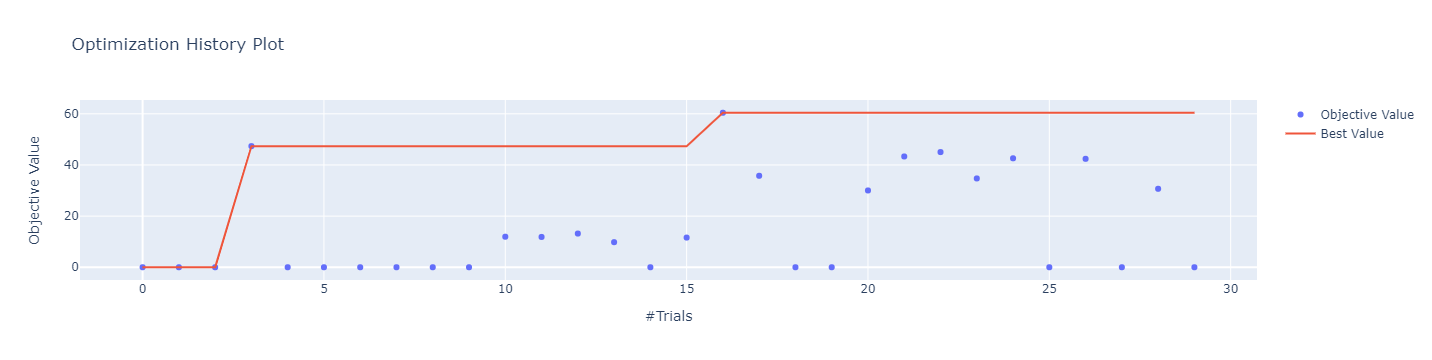

In [37]:
plot_optimization_history(study)

In [ ]:
plot_intermediate_values(study)

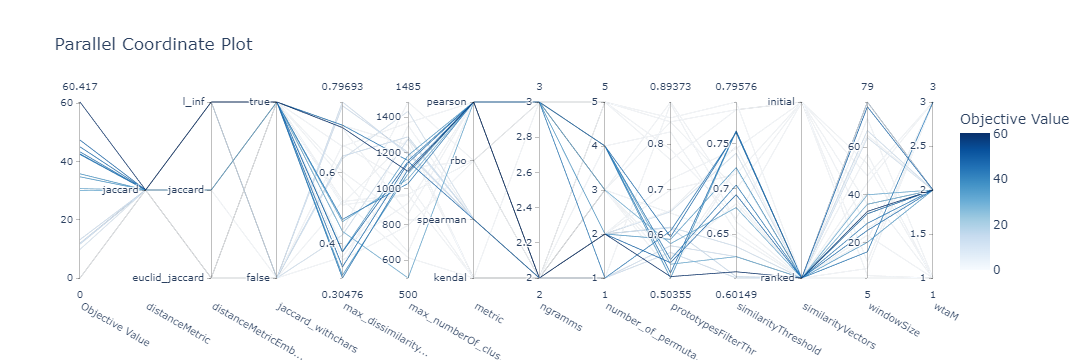

In [39]:
plot_parallel_coordinate(study)

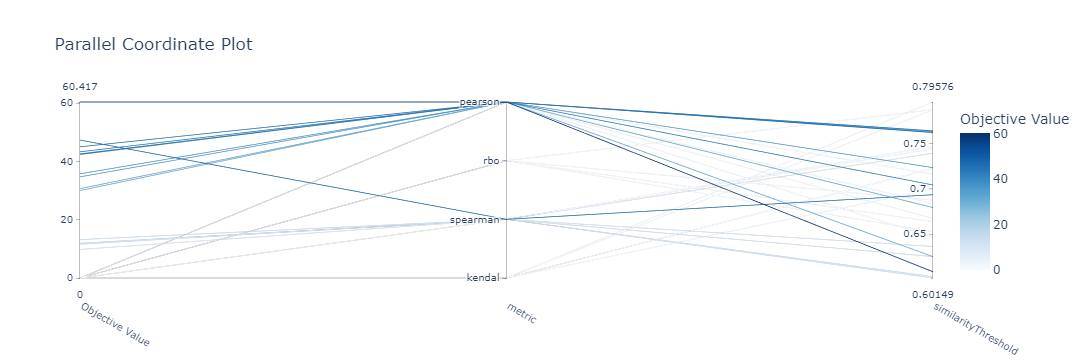

In [40]:
plot_parallel_coordinate(study, params=["metric", "similarityThreshold"])

In [ ]:
plot_contour(study)

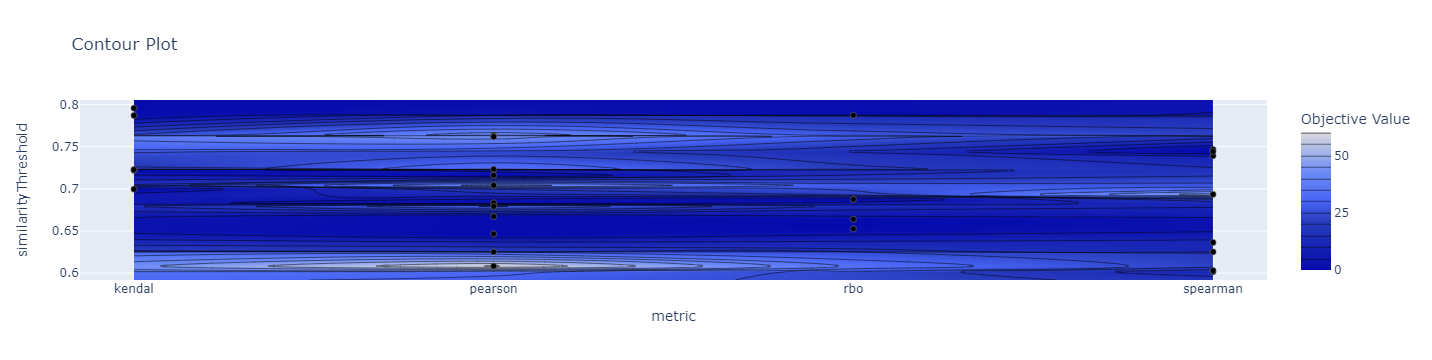

In [42]:
plot_contour(study, params=["metric", "similarityThreshold"])

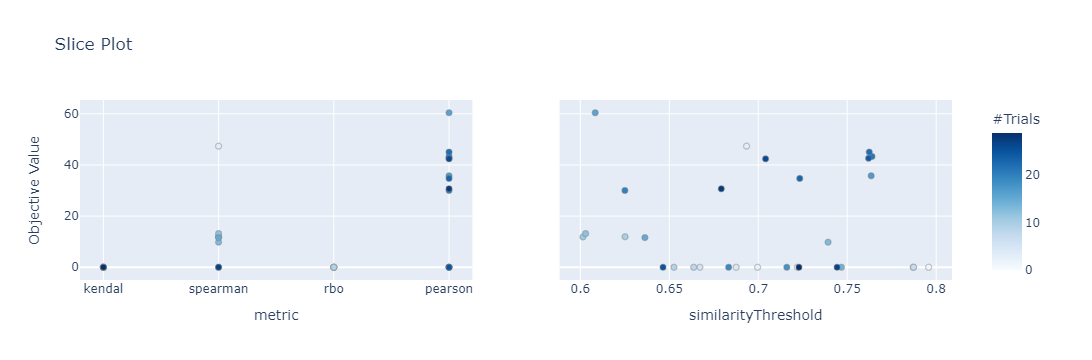

In [43]:
plot_slice(study,  params=["metric", "similarityThreshold"])

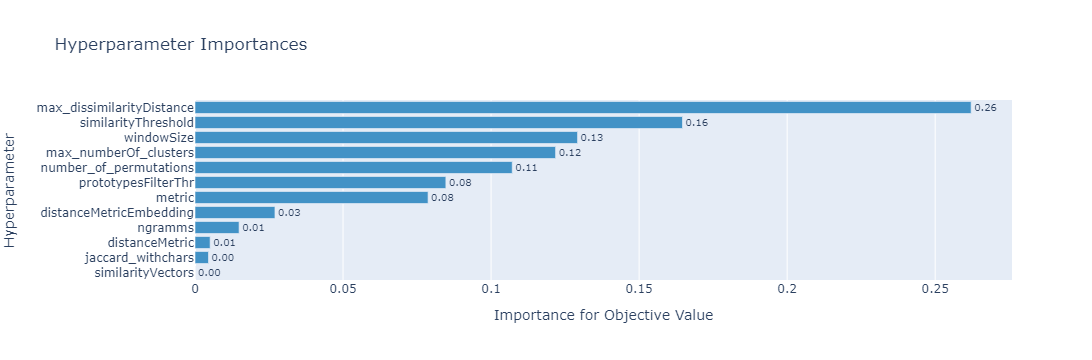

In [33]:
plot_param_importances(study)

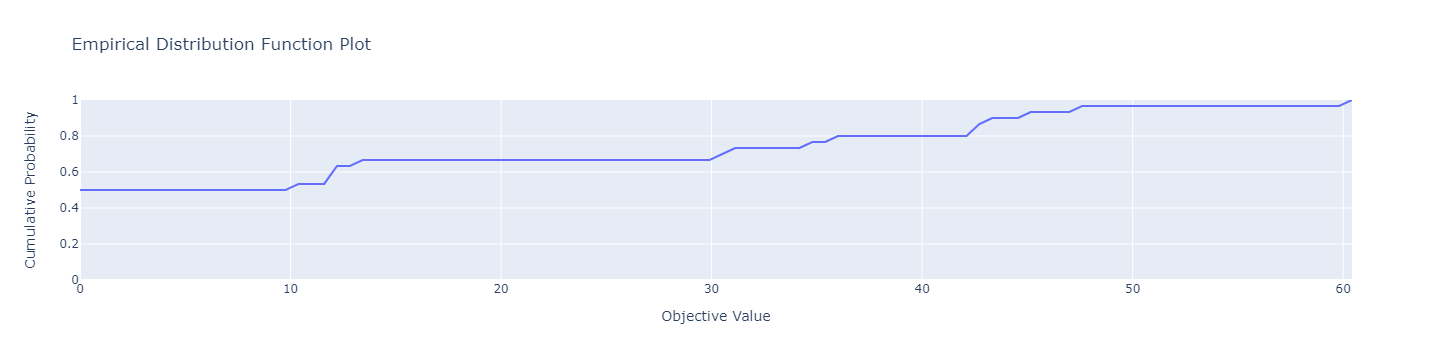

In [45]:
plot_edf(study)

In [53]:
bestModel = set_params(study.best_params)
bestModel.hackForDebug(labels_groundTruth, true_matrix)
bestModel = bestModel.fit(data)
acc,f1,precision,recall = bestModel.evaluate(bestModel.mapping_matrix, true_matrix)

KeyError: 'metric'

# Remarks

## Prototype selection



First of all, we need to find some ways on evaluating the prototype selection algorithm. Vantage Spaces are not something new, but we need to examine its behaviour on CORA dataset.

Goals:

- __Variance__: We want prototypes to be as much different as possible. 
- __Number__: We need a large amount of prototypes.

Ways to evaluate the algorithm:

- Mean distance between selected prototypes
- Show a HeatMap of consisted of the distances
- Some greedy search on the parameters. Parameters to fine tunne:
    -  ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
    -  ```max_dissimilarityDistance```:  The threshold for the triangle inequality
    -  ```distanceMetric```:  Distance metric between the vectors when creating the space
    -  ```prototypesFilterThr```: Prototypes must differ more that threshold


All these parameters will be tested both for edit distance and jaccard with 3-grams.

__Maximum mean discrepancy (MMD)__, which measures the discrepancy between two distributions. The selection of prototypes creates a density distribution of prototypes. We want to evaluate whether the prototypes distribution differs from the data distribution. We estimate both with kernel density functions. The maximum mean discrepancy measures the difference between two distributions, which is the supremum over a function space of differences between the expectations according to the two distributions. All clear? Personally, I understand these concepts much better when I see how something is calculated with data. The following formula shows how to calculate the squared MMD measure (MMD2):
    $$
    MMD^2=\frac{1}{m^2}\sum_{i,j=1}^m{}k(z_i,z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n}k(z_i,x_j)+\frac{1}{n^2}\sum_{i,j=1}^n{}k(x_i,x_j)
    $$
    
- __k__ is a kernel function that measures the similarity of two points
- __m__ is the number of prototypes 
- __n__ is the number of data points x in our original dataset. 
- The prototypes z are a selection of data points x. 

    
Each point is multidimensional, that is it can have multiple features. The goal of MMD-critic is to minimize MMD2. The closer MMD2 is to zero, the better the distribution of the prototypes fits the data. The key to bringing MMD2 down to zero is the term in the middle, which calculates the average proximity between the prototypes and all other data points (multiplied by 2). If this term adds up to the first term (the average proximity of the prototypes to each other) plus the last term (the average proximity of the data points to each other), then the prototypes explain the data perfectly.  

__Remarks__

Two main factors:

- __numOfPrototypes__ and
- __protSelectionVariance__

The first one is the number of prototypes selected, which is very important as more prototypes will enhance model when creating the embeddings.

The second one is the average distance between all the prototypes selected. As this factor increases, the prototypes selected differ the most.


According to the above, best parameters so far:

- __Edit distance__


- __Jaccard with 3-grams__



## Fine tunning  __Embedding phase__


Ways to evaluate the __Embedding phase__:

- Use a PCA after embeddings made and check selected prototypes 

## Fine tunning  __WTA algorithm__



Goals:

- __Ranked vectors dimension__
- __Permutations__: A number of permutations will be forced in order to better split data into buckets.

 
Parameters to fine tunne:

- ```windowSize```: Vector size after WTA
- ```number_of_permutations```: How many times vectors will be permuted and hashed

All these parameters will be tested both for edit distance and jaccard with 3-grams.

## Fine tunning  __Similarity checking__

__Various similarity metrics to check__

These functions are for the similarity checking phase.
- __Spearman footrule distance__
- __Ravi Kumar generalized Kendall Tau__
- __Rank Biased Overlap (RBO)__
Article: https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899
- __Winner Takes All proposed__ 

## Model final fine tunning


There are four ways to check if the predictions are right or wrong:
- __TN__ / True Negative: the case was negative and predicted negative
- __TP__ / True Positive: the case was positive and predicted positive
- __FN__ / False Negative: the case was positive but predicted negative
- __FP__ / False Positive: the case was negative but predicted positive

__Precision — What percent of your predictions were correct?__


Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.
Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)


__Recall — What percent of the positive cases did you catch?__


Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

__F1 score — What percent of positive predictions were correct?__


The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

__Support__


Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)